In [1]:
import xarray as xr 
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
from glob import glob
import netCDF4
from cartopy import crs as ccrs
from cartopy.crs import Stereographic, PlateCarree, Mollweide
from cartopy.feature import LAND, COASTLINE
import cartopy

In [ ]:
# Read files (when in same folder as this notebook)
levitus_file = "Levitus_climatology.nc"
ocean_atmosphere_heat_flux_file = "Ocean-atmosphere_heat-flux.nc"
levitus = xr.open_dataset(levitus_file, engine="scipy", decode_times=False)
oa_heat_flux = xr.open_dataset(ocean_atmosphere_heat_flux_file, engine="scipy", decode_times=False)

# Not yet used
isopycnal_file = "MIMOC_Z_GRID_v2.2_PT_S_month01.nc"
isopycnal = xr.open_dataset(isopycnal_file, decode_times=False)

In [ ]:
# Define given values
specific_heat_capacity = 3.94e3
density = 1024

In [15]:
# Set the basic mapping parameters
suptitle_size = 20
title_size = 16
mapsize = (16, 4)
map_projection = Mollweide()
def basemap(ax):
    ax.add_feature(LAND)
    ax.add_feature(COASTLINE)
    ax.gridlines(draw_labels=["left", "bottom"], y_inline=False, x_inline=False)
    return ax

In [ ]:
# Integrate Temperature over the topmost 1000 meters
integrated_temperature = (
        levitus
        .sel(Z=slice(0,1000)) # Select only the values within the topmost 1000 meters
        .integrate(coord="Z") # Integrate over the depth
        .T # transpose the data
        .temp # Take the Value
    ).rename({"X": "lon", "Y": "lat"}) # Rename the dimensions for easier understanding

In [ ]:
# Calculate the Change in ocean heatcontent over JJA (August - June) and DJF (Feb - Dec) respectively
ocean_heatcontent_change_JJA = (
    density * specific_heat_capacity * 
    (
        integrated_temperature.sel(T=7.5) -
        integrated_temperature.sel(T=5.5)
    )
)
ocean_heatcontent_change_DJF = (
    density * specific_heat_capacity * 
    (
        integrated_temperature.sel(T=1.5) -
        integrated_temperature.sel(T=11.5)
    )
)

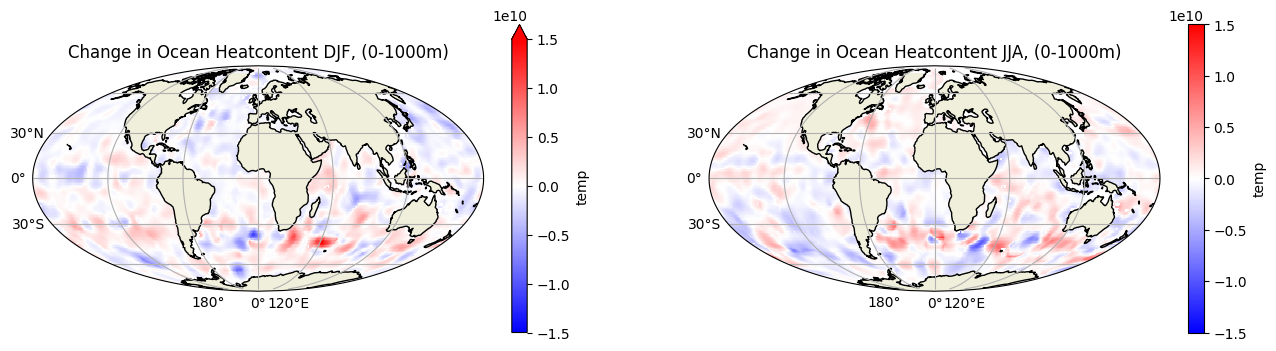

In [22]:
fig = plt.figure(figsize=mapsize)
ax = fig.add_subplot(121, projection=Mollweide())
basemap(ax)
ocean_heatcontent_change_DJF.plot(ax=ax, transform=PlateCarree(), vmin=-1.5e10, vmax=1.5e10, cmap="bwr")
ax.set_title("Change in Ocean Heatcontent DJF, (0-1000m)")
ax = fig.add_subplot(122, projection=Mollweide())
basemap(ax)
ocean_heatcontent_change_JJA.plot(ax=ax, transform=PlateCarree(), vmin=-1.5e10, vmax=1.5e10, cmap="bwr")
ax.set_title("Change in Ocean Heatcontent JJA, (0-1000m)")
plt.show()

In [ ]:
# change the coordinates from -180 - 180 to 0 -360
oa_heat_flux["lon"] = xr.where(
    oa_heat_flux["X"]<0, # take all the values, where X is less than zero
    oa_heat_flux["X"]+360, # if true, add 360
    oa_heat_flux["X"], # if false take them verbatim
)
oa_heat_flux = (
    oa_heat_flux
    .swap_dims({"X": "lon"}) # Make the new values to our dimension
    .sel(**{"lon":sorted(oa_heat_flux.lon_adj)}) # make sure to sort them
    .drop("X") # drop the old Dimension
    .rename({"Y": "lat"}) # rename the Y to lat for easier understanding
)

/tmp/ipykernel_983/3454100831.py:10: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop("X")


In [ ]:
# Get the total heat by multiplying eachs month value with the number of days in that month, 
# summing everything and then multiply by 24*60*60, as the unit is given per second
heatflux_DJF = (
    (oa_heat_flux.hfns.isel(T=11).T + oa_heat_flux.hfns.isel(T=0).T) * 31 + 
    oa_heat_flux.hfns.isel(T=1).T * 28
    ).T *24*60*60
heatflux_JJA = (
    (oa_heat_flux.hfns.isel(T=6).T + oa_heat_flux.hfns.isel(T=7).T)*31 +
    oa_heat_flux.hfns.isel(T=5).T*30
    ).T *24*60*60

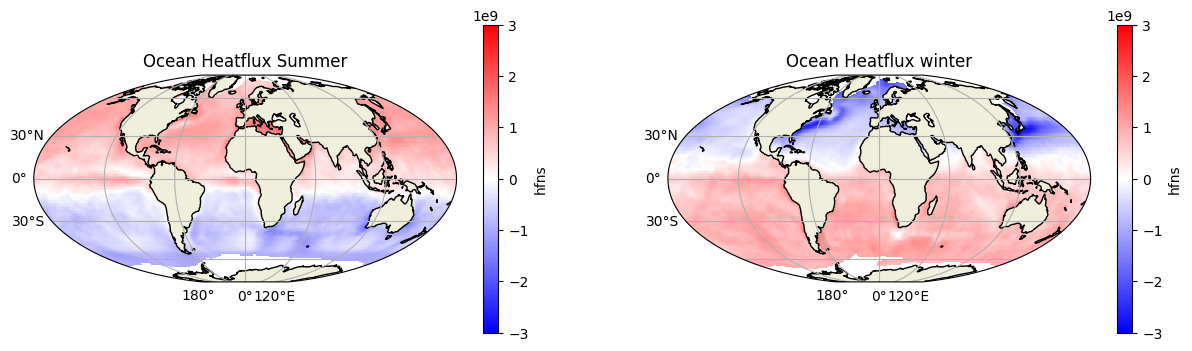

In [ ]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(121, projection=Mollweide())
basemap(ax)
heatflux_JJA.plot(ax=ax, transform=PlateCarree(), vmin=-3e9, vmax=3e9, cmap="bwr")
ax.set_title("Ocean Heatflux JJA")
ax = fig.add_subplot(122, projection=Mollweide())
basemap(ax)
heatflux_DJF.plot(ax=ax, transform=PlateCarree(), vmin=-3e9, vmax=3e9, cmap="bwr")
ax.set_title("Ocean Heatflux DJF")
plt.show()

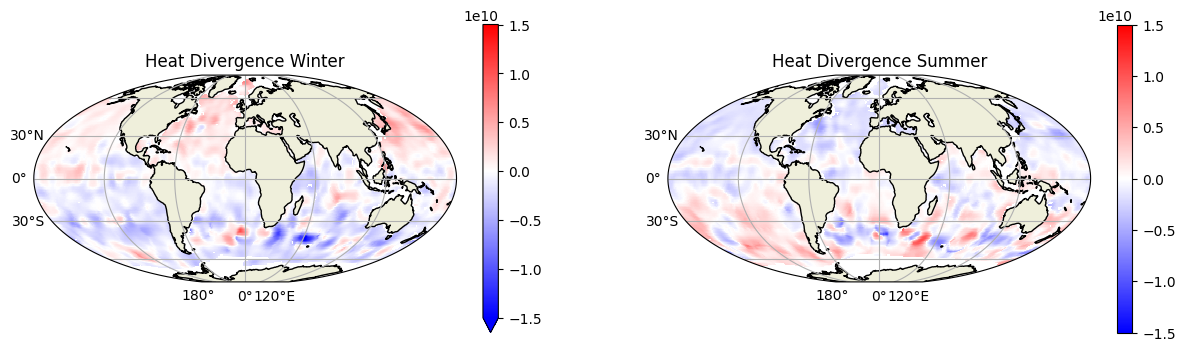

In [ ]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(121, projection=Mollweide())
basemap(ax)
(-heatflux_DJF-ocean_heatcontent_change_DJF).plot(ax=ax, transform=PlateCarree(), vmin=-1.5e10, vmax=1.5e10, cmap="bwr")
ax.set_title("Heat Divergence DJF")
ax = fig.add_subplot(122, projection=Mollweide())
basemap(ax)
(-heatflux_JJA-ocean_heatcontent_change_JJA).plot(ax=ax, transform=PlateCarree(), vmin=-1.5e10, vmax=1.5e10, cmap="bwr")
ax.set_title("Heat Divergence JJA")
plt.show()